# Goal

Accuracy as a function of isotope incorporation

### Variable parameters:

* atom % isotope incorporation
  * 0, 25, 50, 100
* % taxa that incorporate
  * __1, 5, 10, 25, 50__
* n-reps (stocastic: taxon abundances & which incorporate)
  * 10 

## Init

In [1]:
import os
import glob
import itertools
import nestly

In [2]:
%load_ext rpy2.ipython
%load_ext pushnote

In [3]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


### BD min/max

In [4]:
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_BD = min_GC/100.0 * 0.098 + 1.66    
max_BD = max_GC/100.0 * 0.098 + 1.66    

max_BD = max_BD + max_13C_shift_in_BD

print 'Min BD: {}'.format(min_BD)
print 'Max BD: {}'.format(max_BD)

Min BD: 1.67323
Max BD: 1.7744


# Nestly

* assuming fragments already simulated

In [5]:
# paths
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1147/'
buildDir = os.path.join(workDir, 'atomIncorp_taxaIncorp_rerun')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/ampFrags_kde.pkl'
genome_index = '/var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/genome_index.txt'

In [6]:
if not os.path.isdir(buildDir):
    os.makedirs(buildDir)
%cd $buildDir

/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun


In [7]:
# making an experimental design file for qSIP
x = range(1,7)
y = ['control', 'treatment']

expDesignFile = os.path.join(buildDir, 'qSIP_exp_design.txt')
with open(expDesignFile, 'wb') as outFH:
    for i,z in itertools.izip(x,itertools.cycle(y)):
        line = '\t'.join([str(i),z])
        outFH.write(line + '\n')

!head $expDesignFile       

1	control
2	treatment
3	control
4	treatment
5	control
6	treatment


## Nestly params

In [8]:
# building tree structure
nest = nestly.Nest()

# varying params: test
nest.add('percIncorp', [100])
nest.add('percTaxa', [10])
nest.add('rep', range(1,3))

# varying params
#nest.add('percIncorp', [0, 25, 50, 100])
#nest.add('percTaxa', [1, 5, 10, 25, 50])
#nest.add('rep', range(1,11))

## set params
nest.add('abs', ['1e9'], create_dir=False)
nest.add('np', [10], create_dir=False)
nest.add('Monte_rep', [100000], create_dir=False)
nest.add('subsample_dist', ['lognormal'], create_dir=False)
nest.add('subsample_mean', [9.432], create_dir=False)
nest.add('subsample_scale', [0.5], create_dir=False)
nest.add('subsample_min', [10000], create_dir=False)
nest.add('subsample_max', [30000], create_dir=False)
nest.add('min_BD', [min_BD], create_dir=False)
nest.add('max_BD', [max_BD], create_dir=False)
nest.add('DBL_scaling', [0.5], create_dir=False)
nest.add('bandwidth', [0.8], create_dir=False)
nest.add('heavy_BD_min', [1.71], create_dir=False)
nest.add('heavy_BD_max', [1.75], create_dir=False)
nest.add('topTaxaToPlot', [100], create_dir=False)
nest.add('padj', [0.1], create_dir=False)
nest.add('log2', [0.25], create_dir=False)

### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('genome_index', [genome_index], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('exp_design', [expDesignFile], create_dir=False)


# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

## Experimental design

In [9]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_expDesign.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/SIPSimRun_expDesign.sh'

In [10]:
%%writefile $bashFileTmp
#!/bin/bash

echo '#-- Experimental design --#'

echo '# Making an isotope incorporation config file'
echo '## 3 replicate gradients for control & treatment'
SIPSim incorpConfigExample \
  --percIncorpUnif {percIncorp} \
  --n_reps 3 \
  > incorp.config

echo '# Selecting incorporator taxa'
echo '## This is to make the gradient replicates consistent (qSIP finds mean among replicates)'
SIPSim KDE_selectTaxa \
    -p {percTaxa} \
    {fragFile} \
    > incorporators.txt

echo '# Creating a community file (3 replicate control, 3 replicate treatment)'
SIPSim communities \
    --config incorp.config \
    {genome_index} \
    > comm.txt    

echo '# simulating gradient fractions'
SIPSim gradient_fractions \
    --BD_min {min_BD} \
    --BD_max {max_BD} \
    comm.txt \
    > fracs.txt        

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/SIPSimRun_expDesign.sh


In [11]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file exp_design.log -j 10

2016-04-01 11:40:34,747 * INFO * Template: ./SIPSimRun_expDesign.sh
2016-04-01 11:40:34,748 * INFO * [47729] Started ./SIPSimRun_expDesign.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/2
2016-04-01 11:40:34,750 * INFO * [47730] Started ./SIPSimRun_expDesign.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/1
2016-04-01 11:40:39,582 * INFO * [47730] /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/1 Finished with 0
2016-04-01 11:40:39,590 * INFO * [47729] /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/2 Finished with 0


In [12]:
%pushnote exp_design complete: $buildDir

## SIPSim pipeline

In [13]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_SIPSim-pipeline.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/SIPSimRun_SIPSim-pipeline.sh'

In [14]:
%%writefile $bashFileTmp
#!/bin/bash

echo '#-- SIPSim pipeline --#'    
    
echo '# Adding diffusion'    
SIPSim diffusion \
    -n {Monte_rep} \
    --bw {bandwidth} \
    --np {np} \
    {fragFile} \
    > ampFrags_KDE_dif.pkl    

echo '# Adding DBL contamination; abundance-weighted smearing'
SIPSim DBL \
    -n {Monte_rep} \
    --comm comm.txt \
    --commx {DBL_scaling} \
    --np {np} \
    ampFrags_KDE_dif.pkl \
    > ampFrags_KDE_dif_DBL.pkl 

echo '# Adding isotope incorporation to BD distribution'
SIPSim isotope_incorp \
    -n {Monte_rep} \
    --comm comm.txt \
    --taxa incorporators.txt \
    --np {np} \
    ampFrags_KDE_dif_DBL.pkl \
    incorp.config \
    > ampFrags_KDE_dif_DBL_inc.pkl

echo '# Simulating an OTU table'
SIPSim OTU_table \
    --abs {abs} \
    --np {np} \
    ampFrags_KDE_dif_DBL_inc.pkl \
    comm.txt \
    fracs.txt \
    > OTU_abs{abs}.txt
    
echo '# Simulating PCR'
SIPSim OTU_PCR \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_PCR.txt    
    
echo '# Subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}_PCR.txt \
    > OTU_abs{abs}_PCR_sub.txt
        
echo '# Making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_w.txt
    
echo '# Making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_meta.txt
       

#-- removing large intermediate files --#
rm -f ampFrags_KDE_dif.pkl
rm -f ampFrags_KDE_dif_DBL.pkl
rm -f ampFrags_KDE_dif_DBL_inc.pkl    

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/SIPSimRun_SIPSim-pipeline.sh


In [15]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file SIPSim_pipeline.log -j 2

2016-04-01 11:40:40,592 * INFO * Template: ./SIPSimRun_SIPSim-pipeline.sh
2016-04-01 11:40:40,594 * INFO * [47959] Started ./SIPSimRun_SIPSim-pipeline.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/2
2016-04-01 11:40:40,595 * INFO * [47960] Started ./SIPSimRun_SIPSim-pipeline.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/1
2016-04-01 12:16:26,369 * INFO * [47960] /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/1 Finished with 0
2016-04-01 12:18:09,173 * INFO * [47959] /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/2 Finished with 0


In [16]:
%pushnote SIPSim pipeline complete: $buildDir

## Summary of simulated data

In [17]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_SIPSim-summary.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/SIPSimRun_SIPSim-summary.sh'

In [18]:
%%writefile $bashFileTmp
#!/bin/bash
   
# plotting 'raw' taxon abundances
SIPSimR OTU_taxonAbund \
    OTU_abs{abs}.txt \
    -r {topTaxaToPlot} \
    -o OTU_abs{abs}

# plotting 'sequenced' taxon abundances
SIPSimR OTU_taxonAbund \
    OTU_abs{abs}_PCR_sub.txt \
    -r {topTaxaToPlot} \
    -o OTU_abs{abs}_PCR_sub

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/SIPSimRun_SIPSim-summary.sh


In [19]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file SIPSim_summary.log -j 10

2016-04-01 12:18:10,418 * INFO * Template: ./SIPSimRun_SIPSim-summary.sh
2016-04-01 12:18:10,429 * INFO * [55457] Started ./SIPSimRun_SIPSim-summary.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/2
2016-04-01 12:18:10,444 * INFO * [55458] Started ./SIPSimRun_SIPSim-summary.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/1
2016-04-01 12:18:25,725 * INFO * [55457] /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/2 Finished with 0
2016-04-01 12:18:26,228 * INFO * [55458] /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/1 Finished with 0


## HR-SIP: DESeq2

In [20]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_HRSIP.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/SIPSimRun_HRSIP.sh'

In [21]:
%%writefile $bashFileTmp
#!/bin/bash

# phyloseq
## making phyloseq object from OTU table
SIPSimR phyloseq_make \
    OTU_abs{abs}_PCR_sub_w.txt \
    -s OTU_abs{abs}_PCR_sub_meta.txt \
    > OTU_abs{abs}_PCR_sub.physeq

## filtering phyloseq object to just 'heavy' fractions
SIPSimR phyloseq_edit \
    OTU_abs{abs}_PCR_sub.physeq \
    --BD_min {heavy_BD_min} \
    --BD_max {heavy_BD_max} \
    > OTU_abs{abs}_PCR_sub_filt.physeq

## making ordination
SIPSimR phyloseq_ordination \
    OTU_abs{abs}_PCR_sub_filt.physeq \
    OTU_abs{abs}_PCR_sub_filt_bray-NMDS.pdf

# DESeq2
SIPSimR phyloseq_DESeq2 \
    --log2 {log2} \
    --hypo greater \
    --cont 1,3,5 \
    --treat 2,4,6 \
    OTU_abs{abs}_PCR_sub_filt.physeq \
    > OTU_abs{abs}_PCR_sub_filt_DESeq2

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/SIPSimRun_HRSIP.sh


In [22]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file HR-SIP.log -j 10

2016-04-01 12:18:26,507 * INFO * Template: ./SIPSimRun_HRSIP.sh
2016-04-01 12:18:26,508 * INFO * [55554] Started ./SIPSimRun_HRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/2
2016-04-01 12:18:26,510 * INFO * [55555] Started ./SIPSimRun_HRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/1
2016-04-01 12:18:58,961 * INFO * [55555] /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/1 Finished with 0
2016-04-01 12:19:00,485 * INFO * [55554] /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/2 Finished with 0


In [23]:
%pushnote HR-SIP complete: $buildDir

## qSIP

In [24]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_qSIP.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/SIPSimRun_qSIP.sh'

In [25]:
%%writefile $bashFileTmp
#!/bin/bash

# qSIP
SIPSim qSIP \
    OTU_abs{abs}.txt \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_qSIP.txt   

# qSIP: atom excess
SIPSim qSIP_atomExcess \
    --np {np} \
    OTU_abs{abs}_PCR_sub_qSIP.txt \
    {exp_design} \
    > OTU_abs{abs}_PCR_sub_qSIP_atom.txt  

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/SIPSimRun_qSIP.sh


In [26]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file qSIP.log -j 2

2016-04-01 12:19:01,437 * INFO * Template: ./SIPSimRun_qSIP.sh
2016-04-01 12:19:01,438 * INFO * [55801] Started ./SIPSimRun_qSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/2
2016-04-01 12:19:01,440 * INFO * [55802] Started ./SIPSimRun_qSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/1
2016-04-01 13:00:06,946 * INFO * [55801] /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/2 Finished with 0
2016-04-01 13:00:27,380 * INFO * [55802] /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/1 Finished with 0


In [27]:
%pushnote qSIP complete: $buildDir

# Making confusion matrices

In [28]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_cMtx.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/SIPSimRun_cMtx.sh'

In [29]:
%%writefile $bashFileTmp
#!/bin/bash

SIPSimR DESeq2_confuseMtx \
    --libs 2,4,6 \
    --padj {padj} \
    BD-shift_stats.txt \
    OTU_abs{abs}_PCR_sub_filt_DESeq2
    
SIPSimR qSIP_confuseMtx \
    --libs 2,4,6 \
    BD-shift_stats.txt \
    OTU_abs{abs}_PCR_sub_qSIP_atom.txt
     
SIPSimR heavy_confuseMtx \
    --libs 2,4,6 \
    BD-shift_stats.txt \
    OTU_abs{abs}_PCR_sub.txt

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/SIPSimRun_cMtx.sh


In [30]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file cMtx.log -j 10

2016-04-01 13:00:28,410 * INFO * Template: ./SIPSimRun_cMtx.sh
2016-04-01 13:00:28,412 * INFO * [61422] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/2
2016-04-01 13:00:28,414 * INFO * [61423] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/1
2016-04-01 13:00:43,594 * INFO * [61423] /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/1 Finished with 0
2016-04-01 13:00:44,237 * INFO * [61422] /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/100/10/2 Finished with 0


### Aggregating the confusion matrix data

In [31]:
def agg_cMtx(prefix):
    # all data
    !nestagg delim \
        -d $buildDir \
        -k percIncorp,percTaxa,rep \
        -o $prefix-cMtx_data.txt \
        --tab \
        $prefix-cMtx_data.txt

    # overall
    !nestagg delim \
        -d $buildDir \
        -k percIncorp,percTaxa,rep \
        -o $prefix-cMtx_overall.txt \
        --tab \
        $prefix-cMtx_overall.txt

    # by class
    !nestagg delim \
        -d $buildDir \
        -k percIncorp,percTaxa,rep \
        -o $prefix-cMtx_byClass.txt \
        --tab \
        $prefix-cMtx_byClass.txt
        
agg_cMtx('DESeq2') 
agg_cMtx('qSIP') 
agg_cMtx('heavy') 

In [32]:
%pushnote atomIncorp_taxaIncorp complete!

***
# --End of simulation--#
***

# Plotting results

In [33]:
F = os.path.join(buildDir, '*-cMtx_byClass.txt')
files = glob.glob(F)
files

['/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/DESeq2-cMtx_byClass.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/qSIP-cMtx_byClass.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp_rerun/heavy-cMtx_byClass.txt']

In [34]:
%%R -i files

df_byClass = list()
for (f in files){
    ff = strsplit(f, '/') %>% unlist
    fff = ff[length(ff)]
    df_byClass[[fff]] = read.delim(f, sep='\t')
}

df_byClass = do.call(rbind, df_byClass)
df_byClass$file = gsub('\\.[0-9]+$', '', rownames(df_byClass))
df_byClass$method = gsub('-.+', '', df_byClass$file)
rownames(df_byClass) = 1:nrow(df_byClass)

df_byClass %>% head(n=3)

  library      variables    values percIncorp percTaxa rep
1       2    Sensitivity 0.8552632        100       10   2
2       2    Specificity 1.0000000        100       10   2
3       2 Pos Pred Value 1.0000000        100       10   2
                     file method
1 DESeq2-cMtx_byClass.txt DESeq2
2 DESeq2-cMtx_byClass.txt DESeq2
3 DESeq2-cMtx_byClass.txt DESeq2


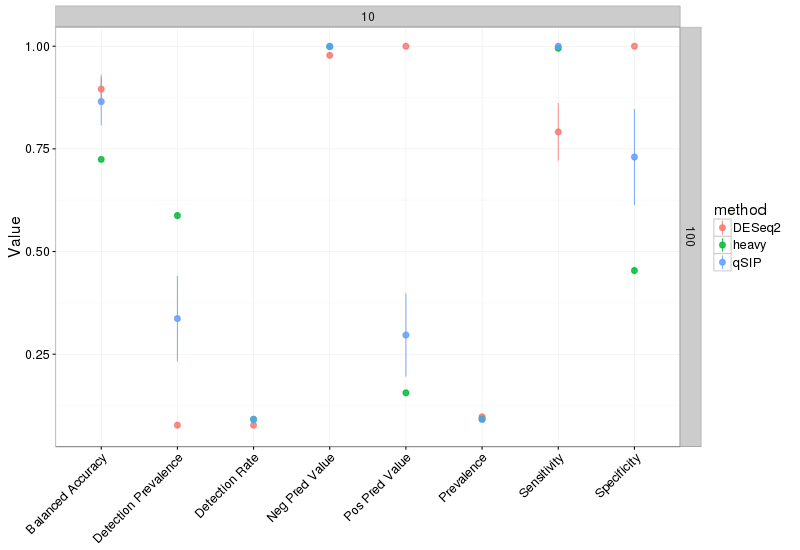

In [35]:
%%R -w 800 -h 550
# summarize by SIPSim rep & library rep
df_byClass.s = df_byClass %>%
    group_by(method, percIncorp, percTaxa, variables) %>%
    summarize(mean_value = mean(values),
              sd_value = sd(values))

# plotting
ggplot(df_byClass.s, aes(variables, mean_value, color=method,
                         ymin=mean_value-sd_value,
                         ymax=mean_value+sd_value)) +
    geom_pointrange(alpha=0.8) +
    labs(y='Value') +
    facet_grid(percIncorp ~ percTaxa) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=45, hjust=1)
    )